In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('final.csv', delimiter=",")

In [3]:
df.shape

(46944, 24)

# Visual LOOK

<AxesSubplot:xlabel='label', ylabel='count'>

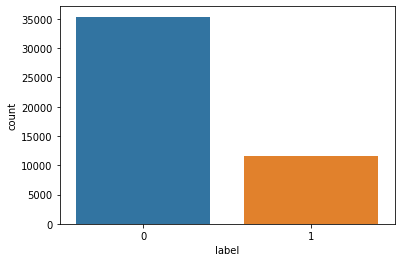

In [4]:
sns.countplot(x = 'label', data = df, order = df['label'].value_counts().index)

In [7]:
df.duplicated().sum()

0

In [6]:
# remove duplicated values
df = df.drop_duplicates(keep='first')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38069 entries, 0 to 46943
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   url                 38069 non-null  object
 1   use_of_ip           38069 non-null  int64 
 2   abnormal_url        38069 non-null  int64 
 3   count.              38069 non-null  int64 
 4   count-www           38069 non-null  int64 
 5   count@              38069 non-null  int64 
 6   count_dir           38069 non-null  int64 
 7   count_embed_domian  38069 non-null  int64 
 8   short_url           38069 non-null  int64 
 9   count-https         38069 non-null  int64 
 10  count-http          38069 non-null  int64 
 11  count%              38069 non-null  int64 
 12  count?              38069 non-null  int64 
 13  count-              38069 non-null  int64 
 14  count=              38069 non-null  int64 
 15  url_length          38069 non-null  int64 
 16  hostname_length     38

# Feature Selection

In [9]:
#Predictor Variables
X = df[['url_length','count-letters', 'count-', 'hostname_length', 'count-www',
       'fd_length', 'count.', 'count-digits', 'count_dir',
       'tld_length']]

#Target Variable
y = df['label']

# Class Distribution

<AxesSubplot:ylabel='label'>

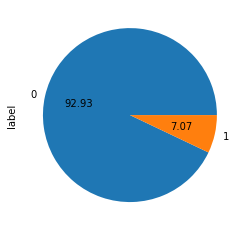

In [10]:
# Show pie plot (Approach 1)
y.value_counts().plot.pie(autopct='%.2f')

([<matplotlib.patches.Wedge at 0x22edb7748e0>,
 [Text(-1.0729877295338506, 0.24227532327868778, '35378'),
  Text(1.0729877465464375, -0.2422752479334165, '2691')],
 [Text(-0.5852660342911912, 0.1321501763338297, '92.93'),
  Text(0.5852660435707839, -0.13215013523640898, '7.07')])

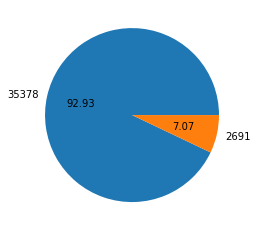

In [11]:
# Show pie plot (Approach 2)
fig1, ax1 = plt.subplots()
ax1.pie(y.value_counts(), autopct='%.2f', labels=y.value_counts())

# Data Splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30455, 10), (30455,), (7614, 10), (7614,))

<AxesSubplot:ylabel='label'>

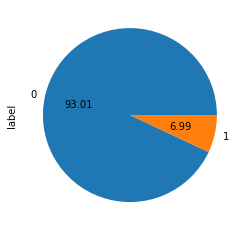

In [14]:
# Pie chart of the training set
y_train.value_counts().plot.pie(autopct='%.2f')

In [15]:
y_train.value_counts()

0    28325
1     2130
Name: label, dtype: int64

# Class Balancing

## Random undersampling

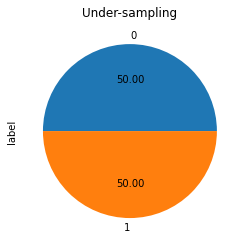

In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
# rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

ax = y_train_rus.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [17]:
# Class distribution
y_train_rus.value_counts()

0    2130
1    2130
Name: label, dtype: int64

## Random Oversampling

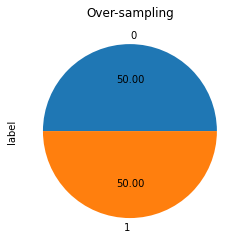

In [18]:
from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy=1) # Float
ros = RandomOverSampler(sampling_strategy="not majority") # String
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

ax = y_train_ros.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [19]:
y_train_ros.value_counts()

0    28325
1    28325
Name: label, dtype: int64

# Model building with/without class balancing

## 1. Model Building without class balancing

In [20]:
# Training Random Forest Models
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42)
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train, y_train, cv=10, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Performa DataTraining
print(confusion_matrix(y_train,y_train_pred))
print(accuracy_score(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))

#Performa Data Test
print(confusion_matrix(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
  
mcc_train = matthews_corrcoef(y_train, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()
print(cv['test_MCC'])

# Display model performance results
df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name = 'Performance_metric_values')
df1 = pd.concat([df_labels, df_values], axis=1)
df1

[[28324     1]
 [    0  2130]]
0.999967164669184
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28325
           1       1.00      1.00      1.00      2130

    accuracy                           1.00     30455
   macro avg       1.00      1.00      1.00     30455
weighted avg       1.00      1.00      1.00     30455

[[7048    5]
 [  19  542]]
0.9968479117415288
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7053
           1       0.99      0.97      0.98       561

    accuracy                           1.00      7614
   macro avg       0.99      0.98      0.99      7614
weighted avg       1.00      1.00      1.00      7614

[0.98221808 0.98221808 0.98477496 0.97709155 0.97452058 0.98221766
 0.96420124 0.97454192 0.95900295 0.97711452]


,Performance_metric_names,Performance_metric_values
0,MCC_train,0.999748
1,MCC_CV,0.975790
2,MCC_test,0.976731


## 2. Model building with undersampled balance class

In [21]:
# Training Random Forest Models
model = RandomForestClassifier(random_state=42)
model.fit(X_train_rus, y_train_rus)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42)
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train_rus, y_train_rus, cv=10, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(X_train_rus)
y_test_pred = model.predict(X_test)

# Performa DataTraining
print(confusion_matrix(y_train_rus,y_train_pred))
print(accuracy_score(y_train_rus,y_train_pred))
print(classification_report(y_train_rus,y_train_pred))

#Performa Data Test
print(confusion_matrix(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
  
mcc_train = matthews_corrcoef(y_train_rus, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()
print(cv['test_MCC'])

# Display model performance results
df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name = 'Performance_metric_values')
df2 = pd.concat([df_labels, df_values], axis=1)
df2

[[2130    0]
 [   0 2130]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2130
           1       1.00      1.00      1.00      2130

    accuracy                           1.00      4260
   macro avg       1.00      1.00      1.00      4260
weighted avg       1.00      1.00      1.00      4260

[[7008   45]
 [   9  552]]
0.9929078014184397
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7053
           1       0.92      0.98      0.95       561

    accuracy                           0.99      7614
   macro avg       0.96      0.99      0.97      7614
weighted avg       0.99      0.99      0.99      7614

[0.990654   0.9860133  0.99061033 0.97187383 0.9860133  0.97187383
 0.95342999 0.97662269 0.95860259 0.98126392]


,Performance_metric_names,Performance_metric_values
0,MCC_train,1.000000
1,MCC_CV,0.976696
2,MCC_test,0.950072


## 3. Model with oversampling balance class

In [22]:
# Training Random Forest Models
model = RandomForestClassifier(random_state=42)
model.fit(X_train_ros, y_train_ros)

# Training Cross-validation Models
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_validate

model_cv = RandomForestClassifier(random_state=42)
cv_scoring = {'MCC': make_scorer(matthews_corrcoef)}
cv = cross_validate(model_cv, X_train_ros, y_train_ros, cv=10, scoring=cv_scoring)

# Apply model to make prediction
from sklearn.metrics import matthews_corrcoef

y_train_pred = model.predict(X_train_ros)
y_test_pred = model.predict(X_test)

# Performa DataTraining
print(confusion_matrix(y_train_ros,y_train_pred))
print(accuracy_score(y_train_ros,y_train_pred))
print(classification_report(y_train_ros,y_train_pred))

#Performa Data Test
print(confusion_matrix(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))
print(classification_report(y_test,y_test_pred))
  
mcc_train = matthews_corrcoef(y_train_ros, y_train_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
mcc_cv = cv['test_MCC'].mean()
print(cv['test_MCC'])

# Display model performance results
df_labels = pd.Series(['MCC_train', 'MCC_CV', 'MCC_test'], name = 'Performance_metric_names')
df_values = pd.Series([mcc_train, mcc_cv, mcc_test], name = 'Performance_metric_values')
df3 = pd.concat([df_labels, df_values], axis=1)
df3

[[28324     1]
 [    0 28325]]
0.999982347749338
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28325
           1       1.00      1.00      1.00     28325

    accuracy                           1.00     56650
   macro avg       1.00      1.00      1.00     56650
weighted avg       1.00      1.00      1.00     56650

[[7048    5]
 [  17  544]]
0.997110585763068
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7053
           1       0.99      0.97      0.98       561

    accuracy                           1.00      7614
   macro avg       0.99      0.98      0.99      7614
weighted avg       1.00      1.00      1.00      7614

[1.         1.         0.99929416 0.99929416 0.99964702 0.99964702
 0.99894143 0.99929416 0.99964702 0.99964702]


,Performance_metric_names,Performance_metric_values
0,MCC_train,0.999965
1,MCC_CV,0.999541
2,MCC_test,0.978689


# Summary of Model Performance

In [23]:
df = pd.concat([df1.Performance_metric_values,
                df2.Performance_metric_values,
                df3.Performance_metric_values], axis=1)
df.columns = ['No class balancing', 'Class balancing (undersampling)', 'Class balancing (oversampling)']
df = df.T
df.columns = ['Training', 'CV', 'Test']
df

,Training,CV,Test
No class balancing,0.999748,0.975790,0.976731
Class balancing (undersampling),1.000000,0.976696,0.950072
Class balancing (oversampling),0.999965,0.999541,0.978689


In [25]:
X_train_ros.to_csv(r'C:\Users\VA2N\TA\final2\features_ros2.csv')

In [26]:
# Menyimpan model Random Forest
import pickle
pickle.dump(model, open('modelIRF.pkl', 'wb'))

# Feature Importance

In [24]:
model_feature = model.feature_importances_
model_feature

array([1.84575111e-04, 5.61052490e-03, 6.90283618e-02, 8.66212651e-02,
       4.87499323e-05, 4.99867273e-02, 4.89900921e-04, 1.95194620e-03,
       2.20709447e-03, 5.57853688e-03, 2.27869046e-02, 8.28632367e-03,
       1.08664765e-01, 2.13052207e-02, 2.26983605e-01, 9.84335485e-02,
       2.16567721e-03, 7.94659485e-02, 3.22563322e-02, 5.09479228e-02,
       1.26996070e-01])

In [25]:
model_feature = model_feature.tolist()

In [27]:
cols = X.columns
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
    
    'RF feature importances': model_feature
                                   
    })
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(21)

C:\Users\VA2N\AppData\Local\Temp/ipykernel_8976/2954114307.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise


,features,RF feature importances,mean
0,use_of_ip,0.000185,0.000185
1,abnormal_url,0.005611,0.005611
2,count.,0.069028,0.069028
3,count-www,0.086621,0.086621
4,count@,0.000049,0.000049
5,count_dir,0.049987,0.049987
6,count_embed_domian,0.000490,0.000490
7,short_url,0.001952,0.001952
8,count-https,0.002207,0.002207
9,count-http,0.005579,0.005579


C:\Users\VA2N\AppData\Local\Temp/ipykernel_8976/2768239687.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


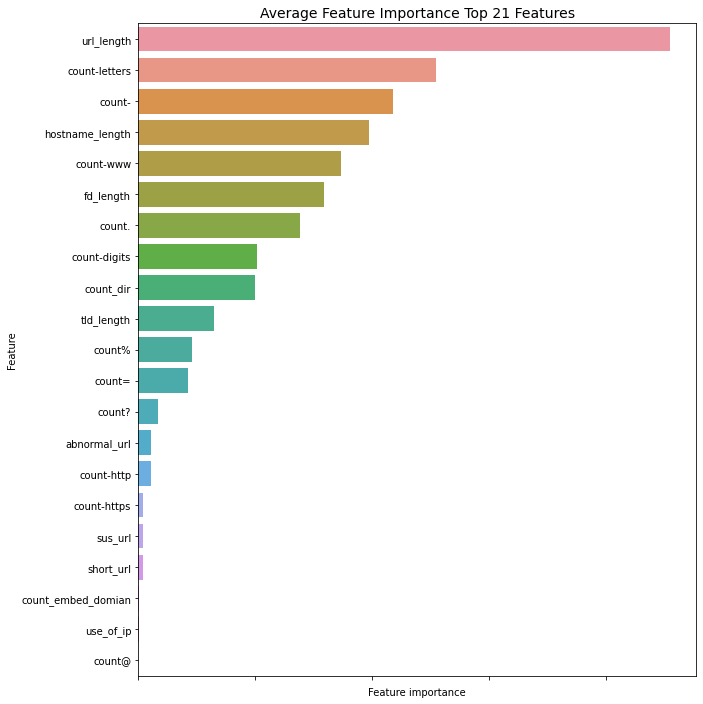

In [28]:
import seaborn as sns
%matplotlib inline
def plot_feature_importance():
    tmp = pd.DataFrame({'Feature': X.columns, 'Feature importance': feature_dataframe['mean'].values})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(21)
    plt.figure(figsize = (10,12))
    plt.title('Average Feature Importance Top 21 Features',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()
plot_feature_importance()